# 💰 EDA: База даних Keitaro (Конверсії)

**Мета**: Розвідувальний аналіз конверсій (депозити та реєстрації) для матчингу з push-сповіщеннями

**Основні завдання**:
1. Дослідити структуру та якість конверсійних даних
2. Знайти цільові кампанії (Michelangelo, Leonardo, Raphael, Splinter)
3. Проаналізувати депозити vs реєстрації
4. Вивчити географічні та часові паттерни конверсій
5. Підготувати дані для матчингу з push-даними по GADID

---

## 🔧 Налаштування середовища

In [16]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
import logging
import json

# Власні модулі
from config.database_config import DatabaseManager
from config.constants import *
from src.database import PushDatabase
from src.data_loader import DataLoader

# Налаштування
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

# Логування
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("📦 Модулі завантажено успішно!")
print(f"📅 Період аналізу конверсій: {CONVERSION_START_DATE} - {CONVERSION_END_DATE}")
print(f"🎯 Цільові застосунки: {TARGET_APPS}")
print(f"📊 Типи конверсій: депозити (is_sale) та реєстрації (is_lead)")

📦 Модулі завантажено успішно!
📅 Період аналізу конверсій: 2025-05-22 - 2025-06-07
🎯 Цільові застосунки: ['Michelangelo', 'Leonardo', 'Raphael', 'Splinter']
📊 Типи конверсій: депозити (is_sale) та реєстрації (is_lead)


## 🔗 Підключення до бази даних Keitaro

In [17]:
# Ініціалізація підключення
db = PushDatabase(cache_enabled=True)
db_manager = DatabaseManager()

# Тестування підключення до keitaro
print("🔍 Тестування підключення до keitaro...")
try:
    keitaro_client = db_manager.connect_keitaro()
    test_result = db_manager.query_to_df(keitaro_client, "SELECT 1 as test")
    print("✅ Підключення до keitaro успішне!")
    
    # Перевірка доступних таблиць
    tables = db_manager.query_to_df(keitaro_client, "SHOW TABLES")
    print(f"📋 Доступні таблиці: {tables['name'].tolist()}")
    
except Exception as e:
    print(f"❌ Помилка підключення: {e}")
    raise

🔍 Тестування підключення до keitaro...
✅ Підключено до keitaro
✅ Підключення до keitaro успішне!
📋 Доступні таблиці: ['keitaro_affiliate_networks', 'keitaro_audit_log_entries', 'keitaro_campaigns', 'keitaro_clicks', 'keitaro_conversions', 'keitaro_domains', 'keitaro_groups', 'keitaro_landings', 'keitaro_offers', 'keitaro_streams', 'keitaro_traffic_sources', 'keitaro_users', 'schema_migrations']


## 🏗️ Дослідження структури даних Keitaro

In [22]:
print("📊 ДОСЛІДЖЕННЯ СХЕМИ БД KEITARO")
print("=" * 50)

# 1. Структура основної таблиці кліків
print("\n🔍 Структура таблиці keitaro_clicks:")
try:
    clicks_schema = db_manager.query_to_df(keitaro_client, "DESCRIBE TABLE keitaro_clicks")
    print(f"Кількість полів: {len(clicks_schema)}")
    print("\nКлючові поля для аналізу:")
    key_fields = ['sub_id_14', 'is_sale', 'is_lead', 'campaign_id', 'country', 'date_key', 
                 'sale_revenue', 'lead_revenue', 'datetime', 'deposits']
    key_schema = clicks_schema[clicks_schema['name'].isin(key_fields)]
    print(key_schema[['name', 'type']].to_string(index=False))
    
except Exception as e:
    print(f"❌ Помилка отримання схеми keitaro_clicks: {e}")

# 2. Структура таблиці кампаній
print("\n🔍 Структура таблиці keitaro_campaigns:")
try:
    campaigns_schema = db_manager.query_to_df(keitaro_client, "DESCRIBE TABLE keitaro_campaigns")
    print("Ключові поля:")
    key_campaign_fields = ['id', 'name', 'alias', 'group_id', 'state', 'created_at']
    key_campaigns_schema = campaigns_schema[campaigns_schema['name'].isin(key_campaign_fields)]
    print(key_campaigns_schema[['name', 'type']].to_string(index=False))
        
except Exception as e:
    print(f"⚠️ Помилка аналізу таблиці кампаній: {e}")

# 3. Структура таблиці груп (НОВА СЕКЦІЯ)
print("\n🔍 Структура таблиці keitaro_groups:")
try:
    groups_schema = db_manager.query_to_df(keitaro_client, "DESCRIBE TABLE keitaro_groups")
    print("Ключові поля:")
    key_group_fields = ['id', 'name', 'type']  # ВИДАЛИЛИ created_at, updated_at
    key_groups_schema = groups_schema[groups_schema['name'].isin(key_group_fields)]
    print(key_groups_schema[['name', 'type']].to_string(index=False))
        
except Exception as e:
    print(f"⚠️ Помилка аналізу таблиці груп: {e}")

# 4. Перевірка цільових груп (НОВА СЕКЦІЯ)
print("\n🎯 Пошук цільових груп (Michelangelo, Leonardo, Raphael, Splinter):")
try:
    target_groups_query = """
    SELECT 
        id,
        name,
        type
    FROM keitaro_groups
    WHERE type = 'campaigns'
        AND (name ILIKE '%michelangelo%' 
             OR name ILIKE '%leonardo%' 
             OR name ILIKE '%raphael%' 
             OR name ILIKE '%splinter%'
             OR id IN (1037, 1038, 1039, 1065))
    ORDER BY id
    """
    
    target_groups = db_manager.query_to_df(keitaro_client, target_groups_query)
    
    if not target_groups.empty:
        print("✅ Знайдені цільові групи:")
        print(target_groups.to_string(index=False))
        
        # Зберігаємо ID цільових груп
        target_group_ids = target_groups['id'].tolist()
        print(f"\n🎯 ID цільових груп: {target_group_ids}")
    else:
        print("⚠️ Цільові групи не знайдено!")
        target_group_ids = [1037, 1038, 1039, 1065]  # Fallback з скріншота
        print(f"🔄 Використовуємо ID з документації: {target_group_ids}")
        
except Exception as e:
    print(f"❌ Помилка пошуку цільових груп: {e}")
    target_group_ids = [1037, 1038, 1039, 1065]

# 5. Перевірка зв'язку groups → campaigns → clicks (НОВА СЕКЦІЯ)
print("\n🔗 Перевірка зв'язку: groups → campaigns → clicks:")
try:
    if 'target_group_ids' in locals():
        ids_filter = ','.join(map(str, target_group_ids))
        
        connection_check_query = f"""
        SELECT 
            g.id as group_id,
            g.name as group_name,
            COUNT(DISTINCT c.id) as campaigns_count,
            COUNT(DISTINCT cl.sub_id_14) as unique_gadids,
            SUM(cl.is_sale) as total_deposits,
            SUM(cl.is_lead) as total_registrations
        FROM keitaro_groups g
        LEFT JOIN keitaro_campaigns c ON g.id = c.group_id
        LEFT JOIN keitaro_clicks cl ON c.id = cl.campaign_id
            AND cl.date_key >= '{CONVERSION_START_DATE}'
            AND cl.date_key <= '{CONVERSION_END_DATE}'
            AND cl.sub_id_14 IS NOT NULL
        WHERE g.id IN ({ids_filter})
        GROUP BY g.id, g.name
        ORDER BY g.id
        """
        
        connection_check = db_manager.query_to_df(keitaro_client, connection_check_query)
        
        print("📊 Зв'язок груп з даними:")
        print(connection_check.to_string(index=False))
        
        # Знаходимо активні групи
        active_groups = connection_check[connection_check['unique_gadids'] > 0]
        if not active_groups.empty:
            print(f"\n✅ Активні групи з даними: {active_groups['group_id'].tolist()}")
            final_target_group_ids = active_groups['group_id'].tolist()
        else:
            print(f"\n⚠️ Групи без даних! Перевіримо всі кампанії...")
            final_target_group_ids = target_group_ids
            
except Exception as e:
    print(f"❌ Помилка перевірки зв'язків: {e}")
    final_target_group_ids = target_group_ids

# 6. Загальна статистика з правильними фільтрами (ОНОВЛЕНА СЕКЦІЯ)
print("\n📊 Загальна статистика keitaro_clicks (ВСІ дані):")
general_stats_query = f"""
SELECT 
    COUNT(*) as total_records,
    COUNT(DISTINCT sub_id_14) as unique_gadids,
    COUNT(DISTINCT campaign_id) as unique_campaigns,
    COUNT(DISTINCT country) as unique_countries,
    MIN(date_key) as earliest_date,
    MAX(date_key) as latest_date,
    SUM(is_sale) as total_deposits,
    SUM(is_lead) as total_registrations
FROM keitaro_clicks
WHERE date_key >= '{CONVERSION_START_DATE}'
    AND date_key <= '{CONVERSION_END_DATE}'
"""

try:
    general_stats = db_manager.query_to_df(keitaro_client, general_stats_query)
    print(general_stats.to_string(index=False))
except Exception as e:
    print(f"❌ Помилка загальної статистики: {e}")

# 7. Статистика для цільових груп (НОВА СЕКЦІЯ)
if 'final_target_group_ids' in locals() and final_target_group_ids:
    print(f"\n📊 Статистика для цільових груп {final_target_group_ids}:")
    
    ids_filter = ','.join(map(str, final_target_group_ids))
    target_stats_query = f"""
    SELECT 
        COUNT(*) as total_records,
        COUNT(DISTINCT cl.sub_id_14) as unique_gadids,
        COUNT(DISTINCT cl.campaign_id) as unique_campaigns,
        COUNT(DISTINCT cl.country) as unique_countries,
        SUM(cl.is_sale) as total_deposits,
        SUM(cl.is_lead) as total_registrations,
        ROUND(SUM(cl.sale_revenue), 2) as total_revenue
    FROM keitaro_clicks cl
    JOIN keitaro_campaigns c ON cl.campaign_id = c.id
    WHERE c.group_id IN ({ids_filter})
        AND cl.date_key >= '{CONVERSION_START_DATE}'
        AND cl.date_key <= '{CONVERSION_END_DATE}'
        AND cl.sub_id_14 IS NOT NULL
    """
    
    try:
        target_stats = db_manager.query_to_df(keitaro_client, target_stats_query)
        print(target_stats.to_string(index=False))
        
        if not target_stats.empty and target_stats.iloc[0]['unique_gadids'] > 0:
            print(f"✅ Цільові групи мають дані! Готово до аналізу.")
        else:
            print(f"⚠️ Цільові групи без даних в поточному періоді.")
            
    except Exception as e:
        print(f"❌ Помилка статистики цільових груп: {e}")

print(f"\n🎯 ПІДСУМОК СХЕМИ:")
print(f"   • Основна таблиця: keitaro_clicks (зв'язок через campaign_id)")
print(f"   • Таблиця кампаній: keitaro_campaigns (зв'язок через group_id)")  
print(f"   • Таблиця груп: keitaro_groups (наші цільові групи)")
print(f"   • Зв'язок: clicks.campaign_id → campaigns.id → campaigns.group_id → groups.id")
if 'final_target_group_ids' in locals():
    print(f"   • Цільові групи для аналізу: {final_target_group_ids}")

📊 ДОСЛІДЖЕННЯ СХЕМИ БД KEITARO

🔍 Структура таблиці keitaro_clicks:
Кількість полів: 100

Ключові поля для аналізу:
        name     type
    date_key     Date
    datetime DateTime
 campaign_id    Int64
     country   String
   sub_id_14   String
lead_revenue  Float64
sale_revenue  Float64
     is_lead    UInt8
     is_sale    UInt8
    deposits    Int64

🔍 Структура таблиці keitaro_campaigns:
Ключові поля:
      name               type
        id              Int64
     alias   Nullable(String)
      name   Nullable(String)
     state   Nullable(String)
created_at Nullable(DateTime)
  group_id              Int64

🔍 Структура таблиці keitaro_groups:
Ключові поля:
name             type
  id            Int64
name Nullable(String)
type Nullable(String)

🎯 Пошук цільових груп (Michelangelo, Leonardo, Raphael, Splinter):
✅ Знайдені цільові групи:
  id                 name      type
1037 Yarik (Michelangelo) campaigns
1038    Zhenya (Leonardo) campaigns
1039     Bohdan (Raphael) campaigns
1

## 🎯 Пошук цільових кампаній

In [21]:
print("🎯 ПОШУК ЦІЛЬОВИХ ГРУП")
print("=" * 40)

# 1. Визначаємо цільові групи
print(f"\n🔍 Пошук цільових груп: {TARGET_APPS}")
target_group_ids = [1037, 1038, 1039, 1065]  # Michelangelo, Leonardo, Raphael, Splinter

# 2. Перевіряємо існування та отримуємо інформацію про групи
print("\n📋 Перевірка цільових груп:")
try:
    ids_filter = ','.join(map(str, target_group_ids))
    
    groups_info_query = f"""
    SELECT 
        id as group_id,
        name as group_name,
        type
    FROM keitaro_groups
    WHERE id IN ({ids_filter})
    ORDER BY id
    """
    
    target_groups = db_manager.query_to_df(keitaro_client, groups_info_query)
    
    if not target_groups.empty:
        print(f"✅ Знайдено {len(target_groups)} цільових груп:")
        print(target_groups.to_string(index=False))
        
        # Використовуємо тільки існуючі групи
        existing_group_ids = target_groups['group_id'].tolist()
        print(f"\n🎯 ID існуючих цільових груп: {existing_group_ids}")
    else:
        print("⚠️ Цільові групи не знайдено!")
        existing_group_ids = []
        
except Exception as e:
    print(f"❌ Помилка перевірки груп: {e}")
    existing_group_ids = target_group_ids  # Fallback

# 3. Знаходимо кампанії, що належать до цільових груп
if existing_group_ids:
    print(f"\n📊 Кампанії в цільових групах:")
    ids_filter = ','.join(map(str, existing_group_ids))
    
    campaigns_in_groups_query = f"""
    SELECT 
        c.id as campaign_id,
        c.name as campaign_name,
        c.alias,
        c.group_id,
        g.name as group_name,
        c.state
    FROM keitaro_campaigns c
    JOIN keitaro_groups g ON c.group_id = g.id
    WHERE c.group_id IN ({ids_filter})
        AND c.state = 'active'
    ORDER BY c.group_id, c.id
    """
    
    try:
        campaigns_in_groups = db_manager.query_to_df(keitaro_client, campaigns_in_groups_query)
        
        if not campaigns_in_groups.empty:
            print(f"✅ Знайдено {len(campaigns_in_groups)} активних кампаній в цільових групах:")
            print(campaigns_in_groups[['campaign_id', 'campaign_name', 'group_id', 'group_name']].to_string(index=False))
            
            # Зберігаємо ID кампаній для подальшого аналізу
            target_campaign_ids = campaigns_in_groups['campaign_id'].tolist()
            print(f"\n🎯 ID кампаній для аналізу: {target_campaign_ids}")
        else:
            print("⚠️ Активні кампанії в цільових групах не знайдено")
            target_campaign_ids = []
            
    except Exception as e:
        print(f"❌ Помилка пошуку кампаній в групах: {e}")
        target_campaign_ids = []

# 4. Альтернативний пошук: топ кампанії в цільових групах за активністю
if not target_campaign_ids and existing_group_ids:
    print("\n🔄 Альтернативний пошук: всі кампанії в цільових групах (включно неактивні):")
    
    all_campaigns_query = f"""
    SELECT 
        c.id as campaign_id,
        c.name,
        c.group_id,
        g.name as group_name,
        c.state,
        COUNT(DISTINCT cl.sub_id_14) as unique_users,
        SUM(cl.is_sale) as total_deposits,
        SUM(cl.is_lead) as total_registrations
    FROM keitaro_campaigns c
    JOIN keitaro_groups g ON c.group_id = g.id
    LEFT JOIN keitaro_clicks cl ON c.id = cl.campaign_id
        AND cl.date_key >= '{CONVERSION_START_DATE}'
        AND cl.date_key <= '{CONVERSION_END_DATE}'
        AND cl.sub_id_14 IS NOT NULL
    WHERE c.group_id IN ({ids_filter})
    GROUP BY c.id, c.name, c.group_id, g.name, c.state
    ORDER BY c.group_id, (total_deposits + total_registrations) DESC
    """
    
    try:
        all_campaigns = db_manager.query_to_df(keitaro_client, all_campaigns_query)
        print(all_campaigns.to_string(index=False))
        
        # Беремо кампанії з даними
        campaigns_with_data = all_campaigns[all_campaigns['unique_users'] > 0]
        if not campaigns_with_data.empty:
            target_campaign_ids = campaigns_with_data['campaign_id'].tolist()
            print(f"\n🎯 Використовуємо кампанії з даними: {target_campaign_ids}")
        
    except Exception as e:
        print(f"❌ Помилка альтернативного пошуку: {e}")

# 5. Детальна статистика по цільових групах через кампанії
if existing_group_ids:
    print(f"\n📈 Детальна статистика цільових груп:")
    ids_filter = ','.join(map(str, existing_group_ids))
    
    group_stats_query = f"""
    SELECT 
        g.id as group_id,
        g.name as group_name,
        COUNT(DISTINCT c.id) as campaigns_count,
        COUNT(DISTINCT cl.sub_id_14) as unique_gadids,
        COUNT(DISTINCT cl.campaign_id) as active_campaigns,
        SUM(cl.is_sale) as deposits,
        SUM(cl.is_lead) as registrations,
        ROUND(SUM(cl.sale_revenue), 2) as total_revenue,
        MIN(cl.date_key) as first_event,
        MAX(cl.date_key) as last_event
    FROM keitaro_groups g
    LEFT JOIN keitaro_campaigns c ON g.id = c.group_id
    LEFT JOIN keitaro_clicks cl ON c.id = cl.campaign_id
        AND cl.date_key >= '{CONVERSION_START_DATE}'
        AND cl.date_key <= '{CONVERSION_END_DATE}'
        AND cl.sub_id_14 IS NOT NULL
    WHERE g.id IN ({ids_filter})
    GROUP BY g.id, g.name
    ORDER BY g.id
    """
    
    try:
        group_stats = db_manager.query_to_df(keitaro_client, group_stats_query)
        print(group_stats.to_string(index=False))
        
        # Підсумкова статистика
        total_users = group_stats['unique_gadids'].sum()
        total_deposits = group_stats['deposits'].sum()
        total_registrations = group_stats['registrations'].sum()
        total_revenue = group_stats['total_revenue'].sum()
        
        print(f"\n✅ ПІДСУМОК ПО ЦІЛЬОВИХ ГРУПАХ:")
        print(f"📊 Загальна кількість GADID: {total_users:,}")
        print(f"💰 Загальна кількість депозитів: {total_deposits:,}")
        print(f"👥 Загальна кількість реєстрацій: {total_registrations:,}")
        print(f"💵 Загальний дохід: ${total_revenue:,.2f}")
        
        # Перевіряємо чи є дані для аналізу
        if total_users > 0:
            print(f"✅ Дані для аналізу є! Групи готові для подальшого дослідження.")
            
            # Показуємо розбивку по групах
            print(f"\n📋 Розбивка по групах:")
            for _, row in group_stats.iterrows():
                if row['unique_gadids'] > 0:
                    print(f"   • {row['group_name']} (ID: {row['group_id']}): {row['unique_gadids']:,} користувачів, {row['deposits']:,} депозитів")
        else:
            print(f"⚠️ У цільових групах немає даних за поточний період!")
            
    except Exception as e:
        print(f"❌ Помилка статистики цільових груп: {e}")

# 6. Перевірка топ активних кампаній взагалі (для порівняння)
print("\n📊 Топ-10 активних кампаній за конверсіями (для порівняння):")
top_campaigns_query = f"""
SELECT 
    cl.campaign_id,
    c.name as campaign_name,
    c.group_id,
    g.name as group_name,
    COUNT(DISTINCT cl.sub_id_14) as unique_users,
    SUM(cl.is_sale) as total_deposits,
    SUM(cl.is_lead) as total_registrations,
    ROUND(SUM(cl.sale_revenue), 2) as total_revenue
FROM keitaro_clicks cl
LEFT JOIN keitaro_campaigns c ON cl.campaign_id = c.id
LEFT JOIN keitaro_groups g ON c.group_id = g.id
WHERE cl.date_key >= '{CONVERSION_START_DATE}'
    AND cl.date_key <= '{CONVERSION_END_DATE}'
    AND cl.sub_id_14 IS NOT NULL
    AND (cl.is_sale > 0 OR cl.is_lead > 0)
GROUP BY cl.campaign_id, c.name, c.group_id, g.name
HAVING total_deposits > 0 OR total_registrations > 0
ORDER BY (total_deposits + total_registrations) DESC
LIMIT 10
"""

try:
    top_campaigns = db_manager.query_to_df(keitaro_client, top_campaigns_query)
    print(top_campaigns.to_string(index=False))
    
    # Перевіряємо чи наші групи в топі
    if 'group_stats' in locals() and not group_stats.empty:
        our_groups_in_top = top_campaigns[top_campaigns['group_id'].isin(existing_group_ids)]
        if not our_groups_in_top.empty:
            print(f"\n✅ Наші цільові групи представлені в топ-10!")
            print(f"🏆 Групи в топі: {our_groups_in_top['group_name'].tolist()}")
        else:
            print(f"\n⚠️ Наші цільові групи не в топ-10 активних")
        
except Exception as e:
    print(f"❌ Помилка топ кампаній: {e}")

# Зберігаємо результати для подальшого використання
if 'existing_group_ids' in locals():
    final_target_group_ids = existing_group_ids
    print(f"\n🎯 ФІНАЛЬНИЙ РЕЗУЛЬТАТ:")
    print(f"   • Цільові групи для аналізу: {final_target_group_ids}")
    if 'target_campaign_ids' in locals() and target_campaign_ids:
        print(f"   • Кампанії в цільових групах: {len(target_campaign_ids)} шт.")
    print(f"   • Готовність до аналізу: {'✅ ТАК' if 'total_users' in locals() and total_users > 0 else '❌ НІ - немає даних'}")
else:
    print("❌ Цільові групи не знайдено!")

🎯 ПОШУК ЦІЛЬОВИХ ГРУП

🔍 Пошук цільових груп: ['Michelangelo', 'Leonardo', 'Raphael', 'Splinter']

📋 Перевірка цільових груп:
✅ Знайдено 4 цільових груп:
 group_id           group_name      type
     1037 Yarik (Michelangelo) campaigns
     1038    Zhenya (Leonardo) campaigns
     1039     Bohdan (Raphael) campaigns
     1065 Splinter (Oleksandr) campaigns

🎯 ID існуючих цільових груп: [1037, 1038, 1039, 1065]

📊 Кампанії в цільових групах:
✅ Знайдено 394 активних кампаній в цільових групах:
 campaign_id                                          campaign_name  group_id           group_name
        1502           Colorful Bright Balloons | com.crossenf.cros      1037 Yarik (Michelangelo)
        2246    Currency Converter | com.projects.currencyconverter      1037 Yarik (Michelangelo)
        2261                            Plinko Goal | com.feresr.wa      1037 Yarik (Michelangelo)
        2274                      Hot Flappy Plin | com.dunamu.stoc      1037 Yarik (Michelangelo)
        

## 🧹 Якість конверсійних даних

In [23]:
print("🔍 АНАЛІЗ ЯКОСТІ КОНВЕРСІЙНИХ ДАНИХ")
print("=" * 50)

# 1. Пропуски в ключових полях
print("\n❌ Аналіз пропусків у ключових полях:")
nulls_query = f"""
SELECT 
    COUNT(*) as total_records,
    SUM(CASE WHEN sub_id_14 IS NULL OR sub_id_14 = '' THEN 1 ELSE 0 END) as gadid_nulls,
    SUM(CASE WHEN campaign_id IS NULL THEN 1 ELSE 0 END) as campaign_nulls,
    SUM(CASE WHEN country IS NULL OR country = '' THEN 1 ELSE 0 END) as country_nulls,
    SUM(CASE WHEN date_key IS NULL THEN 1 ELSE 0 END) as date_nulls,
    SUM(CASE WHEN is_sale IS NULL THEN 1 ELSE 0 END) as sale_nulls,
    SUM(CASE WHEN is_lead IS NULL THEN 1 ELSE 0 END) as lead_nulls
FROM keitaro_clicks
WHERE date_key >= '{CONVERSION_START_DATE}'
    AND date_key <= '{CONVERSION_END_DATE}'
"""

try:
    nulls_stats = db_manager.query_to_df(keitaro_client, nulls_query)
    total_records = nulls_stats['total_records'].iloc[0]
    
    print(f"Загальна кількість записів: {total_records:,}")
    print(f"GADID (sub_id_14) пропуски: {nulls_stats['gadid_nulls'].iloc[0]:,} ({nulls_stats['gadid_nulls'].iloc[0]/total_records*100:.2f}%)")
    print(f"Campaign_ID пропуски: {nulls_stats['campaign_nulls'].iloc[0]:,} ({nulls_stats['campaign_nulls'].iloc[0]/total_records*100:.2f}%)")
    print(f"Country пропуски: {nulls_stats['country_nulls'].iloc[0]:,} ({nulls_stats['country_nulls'].iloc[0]/total_records*100:.2f}%)")
    print(f"Date пропуски: {nulls_stats['date_nulls'].iloc[0]:,} ({nulls_stats['date_nulls'].iloc[0]/total_records*100:.2f}%)")
    print(f"is_sale пропуски: {nulls_stats['sale_nulls'].iloc[0]:,} ({nulls_stats['sale_nulls'].iloc[0]/total_records*100:.2f}%)")
    print(f"is_lead пропуски: {nulls_stats['lead_nulls'].iloc[0]:,} ({nulls_stats['lead_nulls'].iloc[0]/total_records*100:.2f}%)")
    
except Exception as e:
    print(f"❌ Помилка аналізу пропусків: {e}")

# 2. Розподіл типів конверсій
print("\n📊 Розподіл типів конверсій:")
conversion_types_query = f"""
SELECT 
    SUM(CASE WHEN is_sale = 0 AND is_lead = 0 THEN 1 ELSE 0 END) as no_conversion,
    SUM(CASE WHEN is_sale = 0 AND is_lead > 0 THEN 1 ELSE 0 END) as registration_only,
    SUM(CASE WHEN is_sale > 0 AND is_lead = 0 THEN 1 ELSE 0 END) as deposit_only,
    SUM(CASE WHEN is_sale > 0 AND is_lead > 0 THEN 1 ELSE 0 END) as both_conversions,
    SUM(is_sale) as total_deposits,
    SUM(is_lead) as total_registrations,
    COUNT(DISTINCT sub_id_14) as unique_gadids_with_events
FROM keitaro_clicks
WHERE date_key >= '{CONVERSION_START_DATE}'
    AND date_key <= '{CONVERSION_END_DATE}'
    AND sub_id_14 IS NOT NULL
    AND sub_id_14 != ''
"""

try:
    conversion_types = db_manager.query_to_df(keitaro_client, conversion_types_query)
    total_events = (
        conversion_types['no_conversion'].iloc[0] + 
        conversion_types['registration_only'].iloc[0] + 
        conversion_types['deposit_only'].iloc[0] + 
        conversion_types['both_conversions'].iloc[0]
    )
    
    print(f"Записи без конверсій: {conversion_types['no_conversion'].iloc[0]:,} ({conversion_types['no_conversion'].iloc[0]/total_events*100:.2f}%)")
    print(f"Тільки реєстрації: {conversion_types['registration_only'].iloc[0]:,} ({conversion_types['registration_only'].iloc[0]/total_events*100:.2f}%)")
    print(f"Тільки депозити: {conversion_types['deposit_only'].iloc[0]:,} ({conversion_types['deposit_only'].iloc[0]/total_events*100:.2f}%)")
    print(f"Обидва типи: {conversion_types['both_conversions'].iloc[0]:,} ({conversion_types['both_conversions'].iloc[0]/total_events*100:.2f}%)")
    print(f"\nЗагальна кількість депозитів: {conversion_types['total_deposits'].iloc[0]:,}")
    print(f"Загальна кількість реєстрацій: {conversion_types['total_registrations'].iloc[0]:,}")
    print(f"Унікальних GADID з подіями: {conversion_types['unique_gadids_with_events'].iloc[0]:,}")
    
except Exception as e:
    print(f"❌ Помилка аналізу типів конверсій: {e}")

# 3. Статистика доходів
print("\n💰 Статистика доходів:")
revenue_stats_query = f"""
SELECT 
    COUNT(CASE WHEN sale_revenue > 0 THEN 1 END) as deposits_with_revenue,
    ROUND(AVG(CASE WHEN sale_revenue > 0 THEN sale_revenue END), 2) as avg_deposit_amount,
    ROUND(MIN(CASE WHEN sale_revenue > 0 THEN sale_revenue END), 2) as min_deposit_amount,
    ROUND(MAX(CASE WHEN sale_revenue > 0 THEN sale_revenue END), 2) as max_deposit_amount,
    ROUND(SUM(sale_revenue), 2) as total_revenue,
    ROUND(quantile(0.5)(CASE WHEN sale_revenue > 0 THEN sale_revenue END), 2) as median_deposit,
    ROUND(quantile(0.95)(CASE WHEN sale_revenue > 0 THEN sale_revenue END), 2) as p95_deposit
FROM keitaro_clicks
WHERE date_key >= '{CONVERSION_START_DATE}'
    AND date_key <= '{CONVERSION_END_DATE}'
    AND sub_id_14 IS NOT NULL
    AND is_sale > 0
"""

try:
    revenue_stats = db_manager.query_to_df(keitaro_client, revenue_stats_query)
    print(revenue_stats.to_string(index=False))
    
except Exception as e:
    print(f"❌ Помилка аналізу доходів: {e}")

🔍 АНАЛІЗ ЯКОСТІ КОНВЕРСІЙНИХ ДАНИХ

❌ Аналіз пропусків у ключових полях:
Загальна кількість записів: 1,074,667
GADID (sub_id_14) пропуски: 129 (0.01%)
Campaign_ID пропуски: 0 (0.00%)
Country пропуски: 970 (0.09%)
Date пропуски: 0 (0.00%)
is_sale пропуски: 0 (0.00%)
is_lead пропуски: 0 (0.00%)

📊 Розподіл типів конверсій:
Записи без конверсій: 869,279 (80.90%)
Тільки реєстрації: 177,772 (16.54%)
Тільки депозити: 27,487 (2.56%)
Обидва типи: 0 (0.00%)

Загальна кількість депозитів: 27,487
Загальна кількість реєстрацій: 177,772
Унікальних GADID з подіями: 569,073

💰 Статистика доходів:
 deposits_with_revenue  avg_deposit_amount  min_deposit_amount  max_deposit_amount  total_revenue  median_deposit  p95_deposit
                  2777              128.26                 1.0             12512.0      356167.74           145.0       204.66


## ⏰ Часовий аналіз конверсій

📈 ЧАСОВИЙ АНАЛІЗ КОНВЕРСІЙ

📅 Конверсії по днях:
      date  unique_users  total_deposits  total_registrations  daily_revenue  total_events  avg_deposit_amount
2025-05-22         27006            3573                23752       29721.99         27325              128.11
2025-05-23         24899            3490                21622       36394.00         25112              124.64
2025-05-24         19166            2609                16826       45941.21         19435              133.16
2025-05-25         21381            2611                19072       54863.65         21683              127.00
2025-05-26         21136            2966                18477       38615.41         21443              117.02
2025-05-27         19057            2894                16491       32488.64         19385              121.23
2025-05-28         17724            2545                15375       22773.34         17920              127.94
2025-05-29         13849            1747                12248  

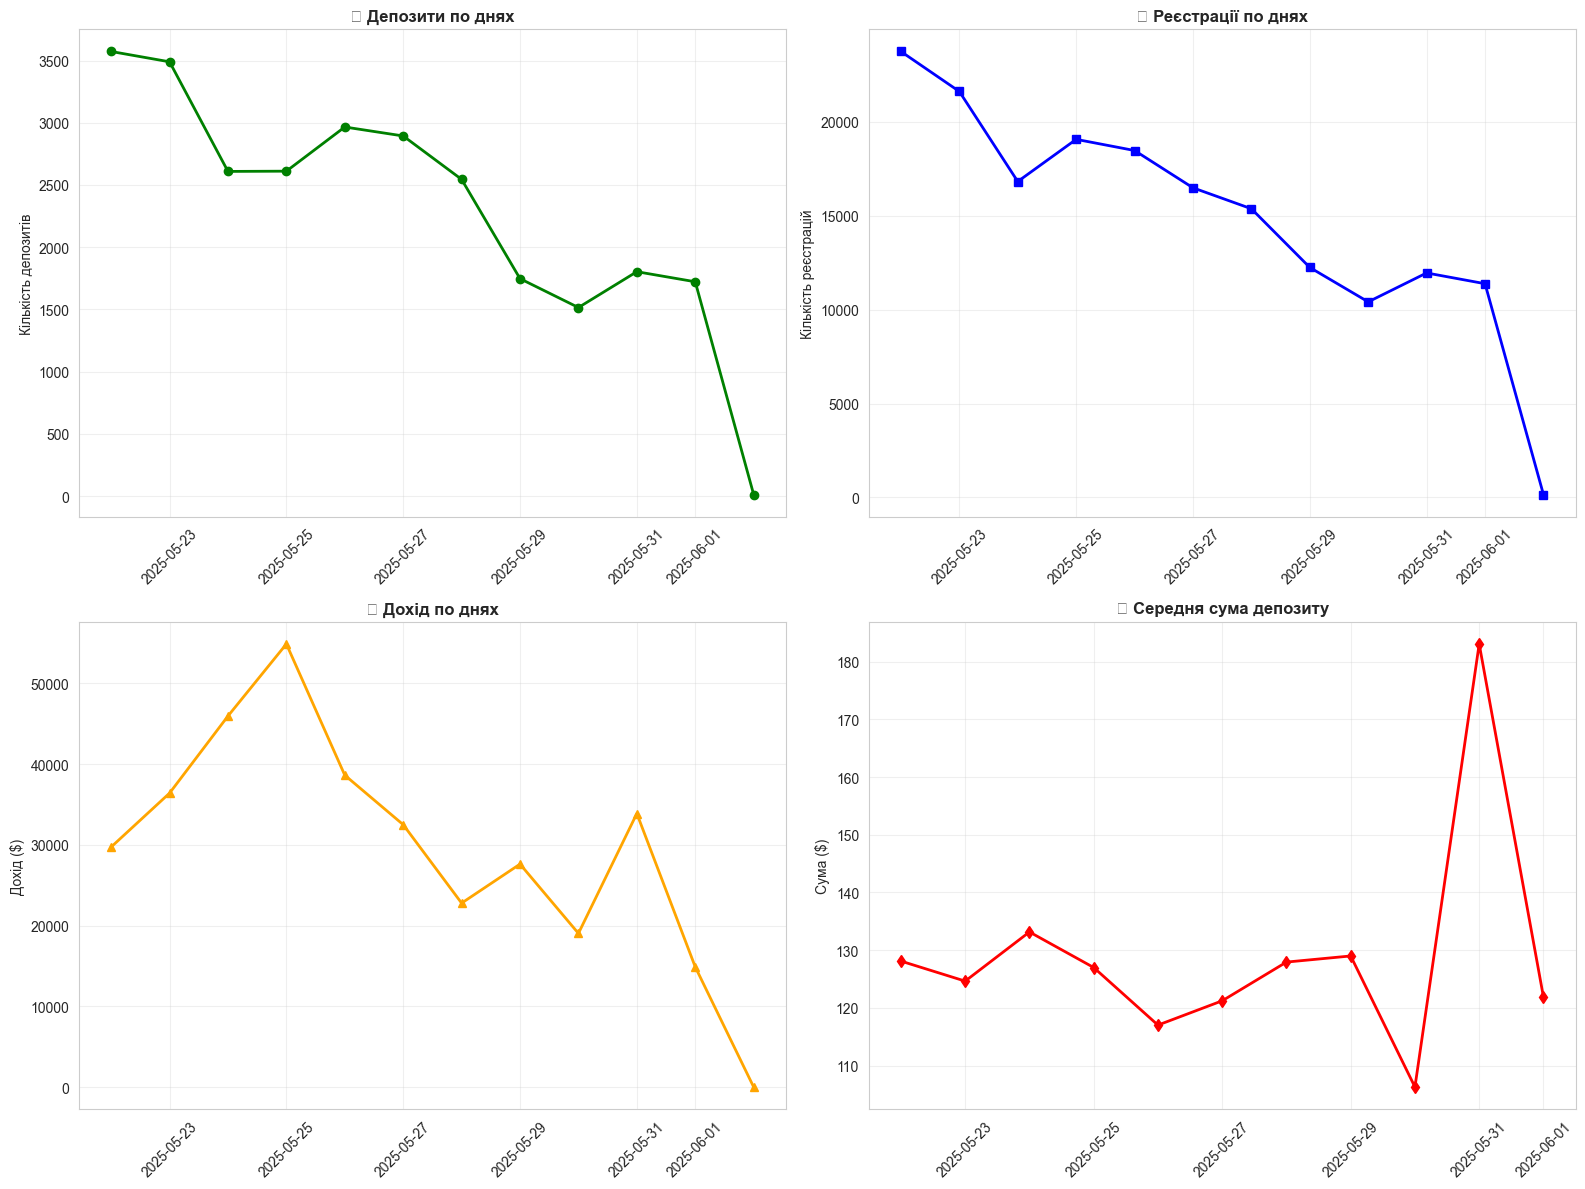


✅ Графік збережено: outputs/charts/daily_conversions_analysis.png

🕐 Аналіз конверсій по годинах:


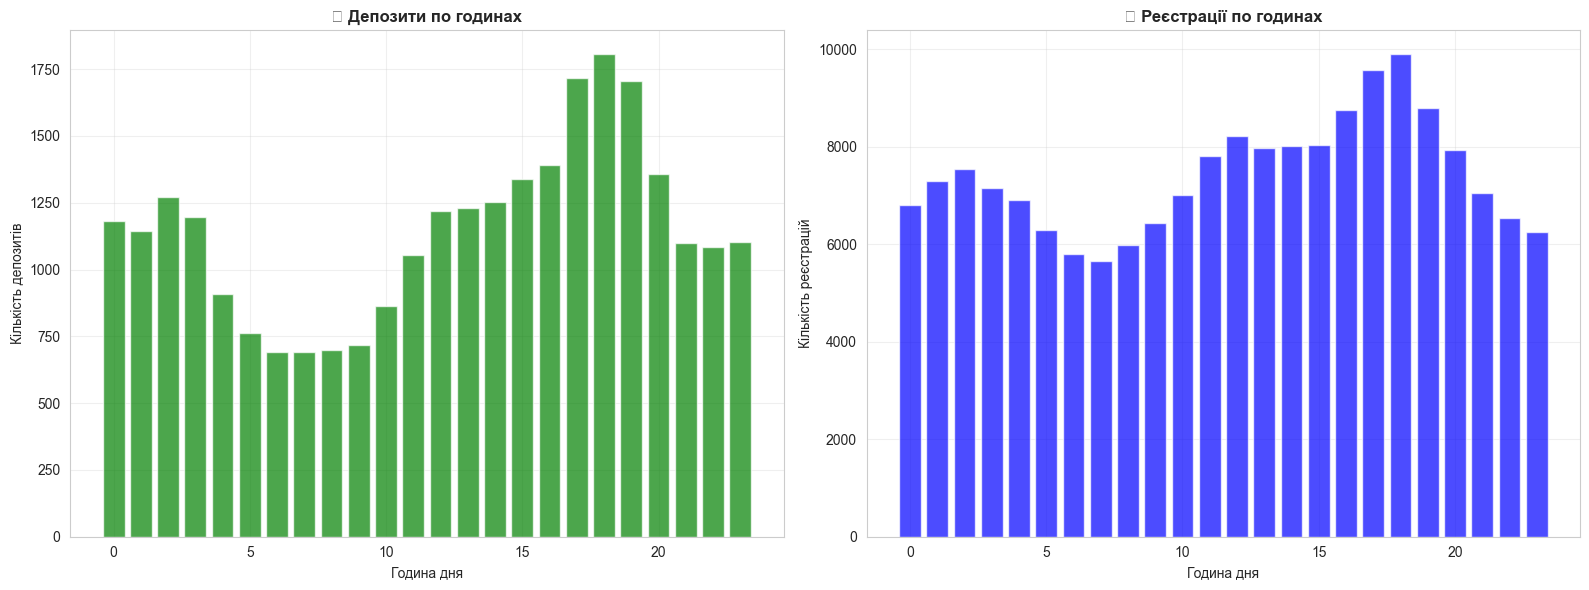


📊 Топ-3 години за депозитами:
 hour  deposits  hourly_revenue
   18      1805        19157.22
   17      1717        17040.59
   19      1707        28789.77


In [8]:
print("📈 ЧАСОВИЙ АНАЛІЗ КОНВЕРСІЙ")
print("=" * 40)

# 1. Конверсії по днях
daily_conversions_query = f"""
SELECT 
    date_key as date,
    COUNT(DISTINCT sub_id_14) as unique_users,
    SUM(is_sale) as total_deposits,
    SUM(is_lead) as total_registrations,
    ROUND(SUM(sale_revenue), 2) as daily_revenue,
    COUNT(*) as total_events,
    ROUND(AVG(CASE WHEN sale_revenue > 0 THEN sale_revenue END), 2) as avg_deposit_amount
FROM keitaro_clicks
WHERE date_key >= '{CONVERSION_START_DATE}'
    AND date_key <= '{CONVERSION_END_DATE}'
    AND sub_id_14 IS NOT NULL
    AND (is_sale > 0 OR is_lead > 0)
GROUP BY date_key
ORDER BY date_key
"""

try:
    daily_conversions = db_manager.query_to_df(keitaro_client, daily_conversions_query)
    daily_conversions['date'] = pd.to_datetime(daily_conversions['date'])
    
    print("\n📅 Конверсії по днях:")
    print(daily_conversions.to_string(index=False))
    
    # Візуалізація часової динаміки
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # График 1: Депозити по днях
    axes[0,0].plot(daily_conversions['date'], daily_conversions['total_deposits'], 
                   marker='o', linewidth=2, markersize=6, color='green')
    axes[0,0].set_title('💰 Депозити по днях', fontsize=12, fontweight='bold')
    axes[0,0].set_ylabel('Кількість депозитів')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)
    
    # График 2: Реєстрації по днях
    axes[0,1].plot(daily_conversions['date'], daily_conversions['total_registrations'], 
                   marker='s', linewidth=2, markersize=6, color='blue')
    axes[0,1].set_title('👥 Реєстрації по днях', fontsize=12, fontweight='bold')
    axes[0,1].set_ylabel('Кількість реєстрацій')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)
    
    # График 3: Дохід по днях
    axes[1,0].plot(daily_conversions['date'], daily_conversions['daily_revenue'], 
                   marker='^', linewidth=2, markersize=6, color='orange')
    axes[1,0].set_title('💵 Дохід по днях', fontsize=12, fontweight='bold')
    axes[1,0].set_ylabel('Дохід ($)')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)
    
    # График 4: Середня сума депозиту
    axes[1,1].plot(daily_conversions['date'], daily_conversions['avg_deposit_amount'], 
                   marker='d', linewidth=2, markersize=6, color='red')
    axes[1,1].set_title('💳 Середня сума депозиту', fontsize=12, fontweight='bold')
    axes[1,1].set_ylabel('Сума ($)')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/charts/daily_conversions_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Графік збережено: outputs/charts/daily_conversions_analysis.png")
    
except Exception as e:
    print(f"❌ Помилка часового аналізу: {e}")

# 2. Аналіз по годинах (якщо є поле datetime)
print("\n🕐 Аналіз конверсій по годинах:")
hourly_conversions_query = f"""
SELECT 
    toHour(datetime) as hour,
    SUM(is_sale) as deposits,
    SUM(is_lead) as registrations,
    COUNT(DISTINCT sub_id_14) as unique_users,
    ROUND(SUM(sale_revenue), 2) as hourly_revenue
FROM keitaro_clicks
WHERE date_key >= '{CONVERSION_START_DATE}'
    AND date_key <= '{CONVERSION_END_DATE}'
    AND sub_id_14 IS NOT NULL
    AND (is_sale > 0 OR is_lead > 0)
    AND datetime IS NOT NULL
GROUP BY toHour(datetime)
ORDER BY hour
"""

try:
    hourly_conversions = db_manager.query_to_df(keitaro_client, hourly_conversions_query)
    
    if not hourly_conversions.empty:
        # Графік розподілу по годинах
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # График 1: Депозити по годинах
        axes[0].bar(hourly_conversions['hour'], hourly_conversions['deposits'], 
                   alpha=0.7, color='green')
        axes[0].set_title('💰 Депозити по годинах', fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Година дня')
        axes[0].set_ylabel('Кількість депозитів')
        axes[0].grid(True, alpha=0.3)
        
        # График 2: Реєстрації по годинах
        axes[1].bar(hourly_conversions['hour'], hourly_conversions['registrations'], 
                   alpha=0.7, color='blue')
        axes[1].set_title('👥 Реєстрації по годинах', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Година дня')
        axes[1].set_ylabel('Кількість реєстрацій')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('../outputs/charts/hourly_conversions.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Топ години
        print("\n📊 Топ-3 години за депозитами:")
        top_deposit_hours = hourly_conversions.nlargest(3, 'deposits')[['hour', 'deposits', 'hourly_revenue']]
        print(top_deposit_hours.to_string(index=False))
        
    else:
        print("⚠️ Дані по годинах не доступні")
        
except Exception as e:
    print(f"⚠️ Аналіз по годинах недоступний: {e}")

## 🌍 Географічний аналіз конверсій

🌍 ГЕОГРАФІЧНИЙ АНАЛІЗ КОНВЕРСІЙ

🏆 Топ-20 країн за конверсіями:
country  unique_users  total_deposits  total_registrations  total_revenue  avg_deposit_amount  deposit_rate  conversion_percentage
     AR         88212           16992                72394         340.00               17.00         19.26                  50.58
     IN         19067             573                18659        3025.00               28.27          3.01                  10.88
     KZ          6764            1094                 6060       28062.00               74.04         16.17                   4.05
     BD          6171             629                 5754           0.00                 NaN         10.19                   3.61
     FR          5018             360                 4868       37985.40              146.66          7.17                   2.96
     IT          4694             425                 4601       48091.43              167.57          9.05                   2.84
     EG          45

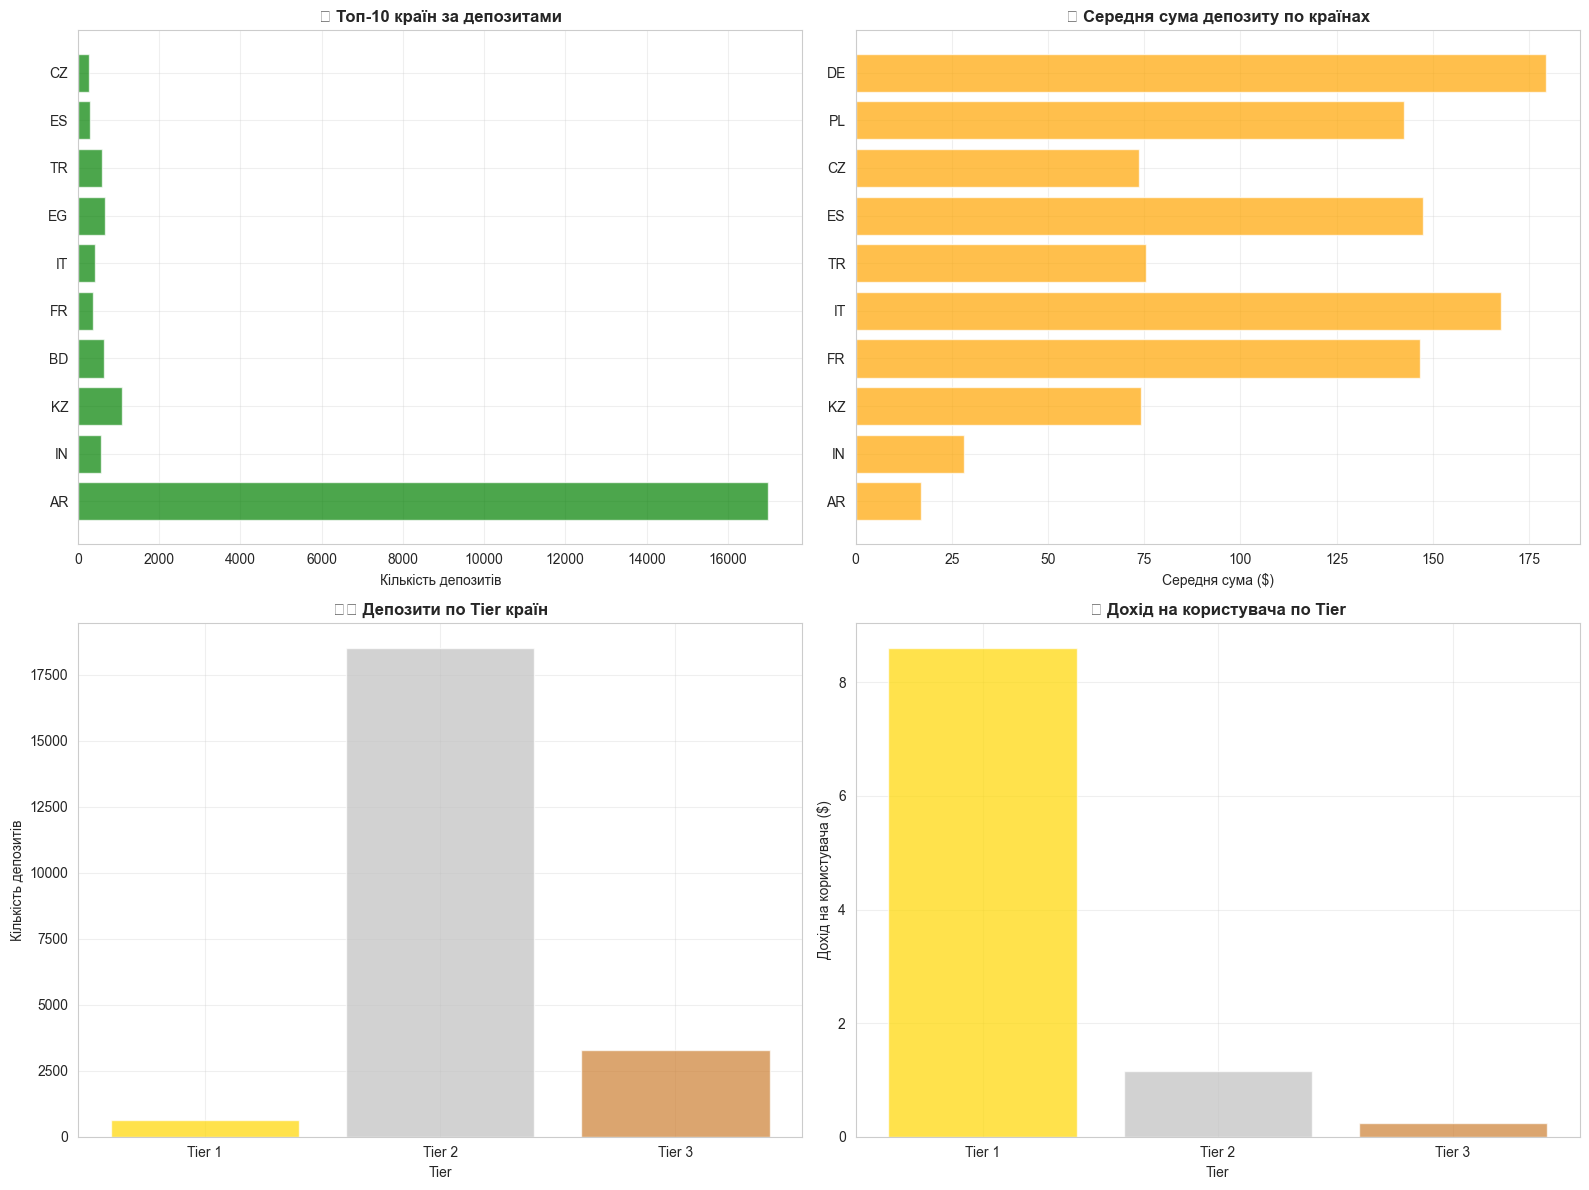


✅ Графік збережено: outputs/charts/geographic_conversions_analysis.png


In [24]:
print("🌍 ГЕОГРАФІЧНИЙ АНАЛІЗ КОНВЕРСІЙ")
print("=" * 45)

# 1. Топ країн за конверсіями
countries_conversions_query = f"""
SELECT 
    COALESCE(country, 'Unknown') as country,
    COUNT(DISTINCT sub_id_14) as unique_users,
    SUM(is_sale) as total_deposits,
    SUM(is_lead) as total_registrations,
    ROUND(SUM(sale_revenue), 2) as total_revenue,
    ROUND(AVG(CASE WHEN sale_revenue > 0 THEN sale_revenue END), 2) as avg_deposit_amount,
    COUNT(*) as total_events
FROM keitaro_clicks
WHERE date_key >= '{CONVERSION_START_DATE}'
    AND date_key <= '{CONVERSION_END_DATE}'
    AND sub_id_14 IS NOT NULL
    AND (is_sale > 0 OR is_lead > 0)
GROUP BY country
ORDER BY (total_deposits + total_registrations) DESC
LIMIT 20
"""

try:
    countries_conversions = db_manager.query_to_df(keitaro_client, countries_conversions_query)
    
    print("\n🏆 Топ-20 країн за конверсіями:")
    # Розраховуємо відсотки
    total_conversions = (countries_conversions['total_deposits'] + countries_conversions['total_registrations']).sum()
    countries_conversions['conversion_percentage'] = (
        (countries_conversions['total_deposits'] + countries_conversions['total_registrations']) / total_conversions * 100
    ).round(2)
    
    # Розраховуємо коефіцієнти конверсії
    countries_conversions['deposit_rate'] = (
        countries_conversions['total_deposits'] / countries_conversions['unique_users'] * 100
    ).round(2)
    
    countries_conversions['registration_rate'] = (
        countries_conversions['total_registrations'] / countries_conversions['unique_users'] * 100
    ).round(2)
    
    display_columns = ['country', 'unique_users', 'total_deposits', 'total_registrations', 
                      'total_revenue', 'avg_deposit_amount', 'deposit_rate', 'conversion_percentage']
    print(countries_conversions[display_columns].to_string(index=False))
    
    # Додавання tier класифікації
    countries_conversions['tier'] = countries_conversions['country'].apply(get_country_tier)
    
    print("\n🏷️ Розподіл конверсій по Tier:")
    tier_conversions = countries_conversions[countries_conversions['country'] != 'Unknown'].groupby('tier').agg({
        'unique_users': 'sum',
        'total_deposits': 'sum',
        'total_registrations': 'sum',
        'total_revenue': 'sum',
        'avg_deposit_amount': 'mean',
        'country': 'count'
    }).round(2)
    
    tier_conversions.columns = ['unique_users', 'total_deposits', 'total_registrations', 
                               'total_revenue', 'avg_deposit_amount', 'countries_count']
    
    # Розраховуємо коефіцієнти по tier
    tier_conversions['deposit_rate'] = (
        tier_conversions['total_deposits'] / tier_conversions['unique_users'] * 100
    ).round(2)
    
    tier_conversions['revenue_per_user'] = (
        tier_conversions['total_revenue'] / tier_conversions['unique_users']
    ).round(2)
    
    print(tier_conversions.to_string())
    
    # Візуалізація географічного розподілу
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # График 1: Топ-10 країн за депозитами
    top_countries = countries_conversions.head(10)
    axes[0,0].barh(range(len(top_countries)), top_countries['total_deposits'], alpha=0.7, color='green')
    axes[0,0].set_yticks(range(len(top_countries)))
    axes[0,0].set_yticklabels(top_countries['country'])
    axes[0,0].set_title('💰 Топ-10 країн за депозитами', fontsize=12, fontweight='bold')
    axes[0,0].set_xlabel('Кількість депозитів')
    axes[0,0].grid(True, alpha=0.3)
    
    # График 2: Середня сума депозиту по країнах
    top_revenue_countries = countries_conversions[countries_conversions['avg_deposit_amount'].notna()].head(10)
    axes[0,1].barh(range(len(top_revenue_countries)), top_revenue_countries['avg_deposit_amount'], 
                   alpha=0.7, color='orange')
    axes[0,1].set_yticks(range(len(top_revenue_countries)))
    axes[0,1].set_yticklabels(top_revenue_countries['country'])
    axes[0,1].set_title('💵 Середня сума депозиту по країнах', fontsize=12, fontweight='bold')
    axes[0,1].set_xlabel('Середня сума ($)')
    axes[0,1].grid(True, alpha=0.3)
    
    # График 3: Розподіл по Tier (депозити)
    if not tier_conversions.empty:
        tier_data = tier_conversions.reset_index()
        tier_data = tier_data[tier_data['tier'] != 'Other']
        
        if not tier_data.empty:
            colors = {'Tier 1': 'gold', 'Tier 2': 'silver', 'Tier 3': '#CD7F32'}
            tier_colors = [colors.get(tier, 'gray') for tier in tier_data['tier']]
            
            axes[1,0].bar(tier_data['tier'], tier_data['total_deposits'], alpha=0.7, color=tier_colors)
            axes[1,0].set_title('🏷️ Депозити по Tier країн', fontsize=12, fontweight='bold')
            axes[1,0].set_xlabel('Tier')
            axes[1,0].set_ylabel('Кількість депозитів')
            axes[1,0].grid(True, alpha=0.3)
            
            # График 4: Дохід на користувача по Tier
            axes[1,1].bar(tier_data['tier'], tier_data['revenue_per_user'], alpha=0.7, color=tier_colors)
            axes[1,1].set_title('💰 Дохід на користувача по Tier', fontsize=12, fontweight='bold')
            axes[1,1].set_xlabel('Tier')
            axes[1,1].set_ylabel('Дохід на користувача ($)')
            axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/charts/geographic_conversions_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Графік збережено: outputs/charts/geographic_conversions_analysis.png")
    
except Exception as e:
    print(f"❌ Помилка географічного аналізу: {e}")

## 🎯 Аналіз цільових кампаній

🎯 АНАЛІЗ ЦІЛЬОВИХ ГРУП

📊 Детальний аналіз цільових груп: [1037, 1038, 1039, 1065]

📈 Порівняння кампаній в цільових групах:
 campaign_id                                          campaign_name           group_name  unique_gadids  total_deposits  total_revenue
        2826                                Plin Beans | com.westbu    Zhenya (Leonardo)          59024            1584       86496.31
        2860                   Plin Fever: Rush | com.gamemaker5.id Splinter (Oleksandr)          30999             895       68534.78
        2799                     Emerald Balls | com.funplus.family     Bohdan (Raphael)          32624             878       27116.22
        2879                             Vortex Drop | com.getactio    Zhenya (Leonardo)           6643             157       21060.04
        2887                         Plin Jump | com.fusionprojects    Zhenya (Leonardo)          19078             606       17018.19
        2892                                Lucky Ball | com.steu

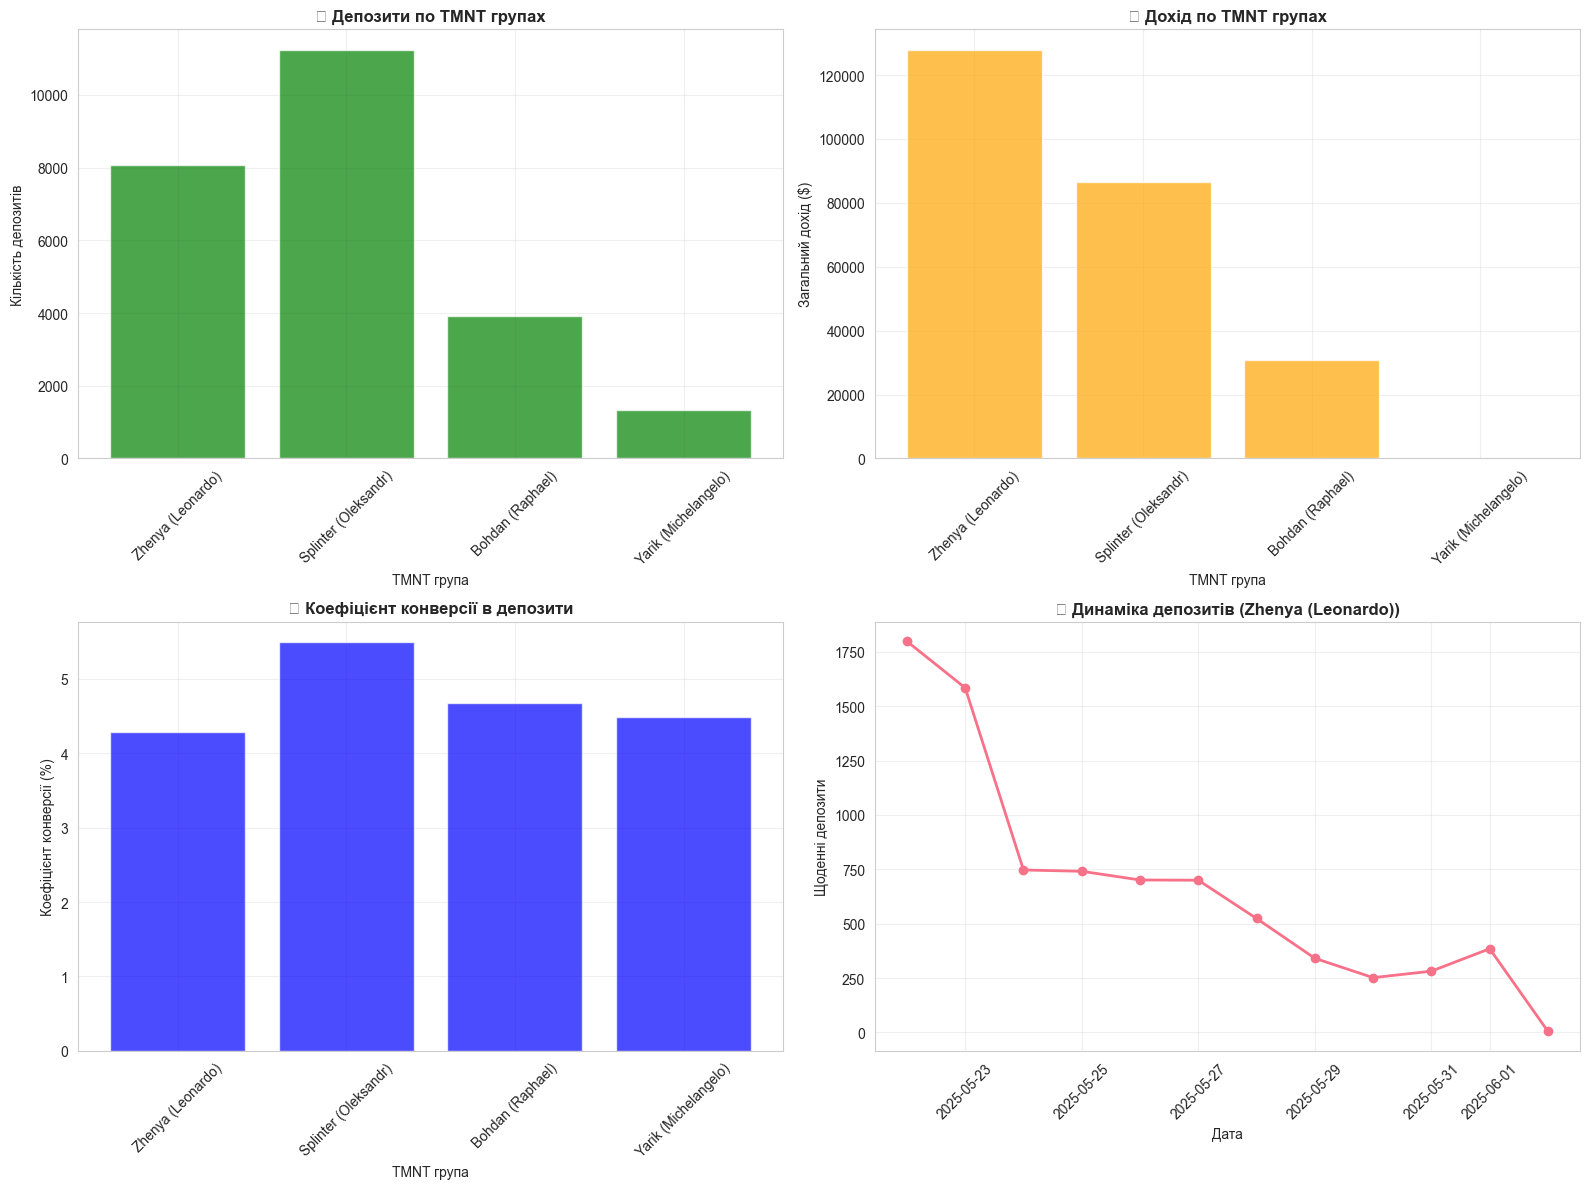


✅ Графік збережено: outputs/charts/tmnt_groups_analysis.png

🌍 Топ-10 країн для цільових TMNT груп:
country  deposits  registrations  revenue  unique_users
     AR     16364          70658   340.00         85895
     BD       621           5688     0.00          6103
     IN        91           5831   780.00          5861
     KZ       918           4770 28007.00          5383
     TR       564           3804    40.00          4242
     FR       276           3737 28831.09          3891
     EG       544           3189     0.00          3665
     IT       278           3087 24025.78          3199
     ZA       441           2849     0.00          3247
     PL       292           2794 26134.39          2965

🎯 ПІДСУМОК TMNT ГРУП:
   🐢 Усього користувачів: 506,298
   💰 Усього депозитів: 24,549
   💵 Загальний дохід: $245,628.21
   📊 Середній коефіцієнт конверсії: 4.74%
   💳 ARPU: $0.49

🏆 Найкраща група за доходом:
   • Zhenya (Leonardo): $127,925.75 доходу
   • 188,067 користувачів, 4.2

In [26]:
print("🎯 АНАЛІЗ ЦІЛЬОВИХ ГРУП")  
print("=" * 40)

if 'final_target_group_ids' in locals() and final_target_group_ids: 
    print(f"\n📊 Детальний аналіз цільових груп: {final_target_group_ids}")
    
    # Формуємо фільтр для цільових груп
    ids_filter = ','.join(map(str, final_target_group_ids))
    
    # 1. Порівняння кампаній в цільових групах
    campaign_comparison_query = f"""
    SELECT 
        cl.campaign_id,
        c.name as campaign_name,
        c.group_id,
        g.name as group_name,
        COUNT(DISTINCT cl.sub_id_14) as unique_gadids,
        SUM(cl.is_sale) as total_deposits,
        SUM(cl.is_lead) as total_registrations,
        ROUND(SUM(cl.sale_revenue), 2) as total_revenue,
        ROUND(AVG(CASE WHEN cl.sale_revenue > 0 THEN cl.sale_revenue END), 2) as avg_deposit_amount,
        COUNT(DISTINCT cl.country) as countries_covered,
        ROUND(SUM(cl.is_sale) * 100.0 / COUNT(DISTINCT cl.sub_id_14), 2) as deposit_rate,
        ROUND(SUM(cl.is_lead) * 100.0 / COUNT(DISTINCT cl.sub_id_14), 2) as registration_rate
    FROM keitaro_clicks cl
    JOIN keitaro_campaigns c ON cl.campaign_id = c.id
    JOIN keitaro_groups g ON c.group_id = g.id
    WHERE c.group_id IN ({ids_filter})
        AND cl.date_key >= '{CONVERSION_START_DATE}'
        AND cl.date_key <= '{CONVERSION_END_DATE}'
        AND cl.sub_id_14 IS NOT NULL
        AND cl.sub_id_14 != ''
    GROUP BY cl.campaign_id, c.name, c.group_id, g.name
    ORDER BY total_revenue DESC
    """
    
    try:
        campaign_comparison = db_manager.query_to_df(keitaro_client, campaign_comparison_query)
        
        print("\n📈 Порівняння кампаній в цільових групах:")
        print(campaign_comparison[['campaign_id', 'campaign_name', 'group_name', 'unique_gadids', 'total_deposits', 'total_revenue']].to_string(index=False))
        
        # 2. Агрегація по групах 
        group_summary_query = f"""
        SELECT 
            g.id as group_id,
            g.name as group_name,
            COUNT(DISTINCT cl.campaign_id) as campaigns_count,
            COUNT(DISTINCT cl.sub_id_14) as unique_gadids,
            SUM(cl.is_sale) as total_deposits,
            SUM(cl.is_lead) as total_registrations,
            ROUND(SUM(cl.sale_revenue), 2) as total_revenue,
            ROUND(AVG(CASE WHEN cl.sale_revenue > 0 THEN cl.sale_revenue END), 2) as avg_deposit_amount,
            ROUND(SUM(cl.is_sale) * 100.0 / COUNT(DISTINCT cl.sub_id_14), 2) as deposit_rate
        FROM keitaro_clicks cl
        JOIN keitaro_campaigns c ON cl.campaign_id = c.id
        JOIN keitaro_groups g ON c.group_id = g.id
        WHERE c.group_id IN ({ids_filter})
            AND cl.date_key >= '{CONVERSION_START_DATE}'
            AND cl.date_key <= '{CONVERSION_END_DATE}'
            AND cl.sub_id_14 IS NOT NULL
            AND cl.sub_id_14 != ''
        GROUP BY g.id, g.name
        ORDER BY total_revenue DESC
        """
        
        group_summary = db_manager.query_to_df(keitaro_client, group_summary_query)
        
        print("\n🐢 Підсумок по TMNT групах:")
        print(group_summary.to_string(index=False))
        
        # 3. Часова динаміка по групах
        group_timeline_query = f"""
        SELECT 
            c.group_id,
            g.name as group_name,
            cl.date_key as date,
            SUM(cl.is_sale) as daily_deposits,
            SUM(cl.is_lead) as daily_registrations,
            COUNT(DISTINCT cl.sub_id_14) as daily_users,
            ROUND(SUM(cl.sale_revenue), 2) as daily_revenue
        FROM keitaro_clicks cl
        JOIN keitaro_campaigns c ON cl.campaign_id = c.id
        JOIN keitaro_groups g ON c.group_id = g.id
        WHERE c.group_id IN ({ids_filter})
            AND cl.date_key >= '{CONVERSION_START_DATE}'
            AND cl.date_key <= '{CONVERSION_END_DATE}'
            AND cl.sub_id_14 IS NOT NULL
            AND (cl.is_sale > 0 OR cl.is_lead > 0)
        GROUP BY c.group_id, g.name, cl.date_key
        ORDER BY c.group_id, cl.date_key
        """
        
        group_timeline = db_manager.query_to_df(keitaro_client, group_timeline_query)
        
        if not group_timeline.empty and not group_summary.empty:
            group_timeline['date'] = pd.to_datetime(group_timeline['date'])
            
            # Візуалізація порівняння груп
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            
            # График 1: Депозити по групах
            axes[0,0].bar(group_summary['group_name'], 
                         group_summary['total_deposits'], alpha=0.7, color='green')
            axes[0,0].set_title('💰 Депозити по TMNT групах', fontsize=12, fontweight='bold')
            axes[0,0].set_xlabel('TMNT група')
            axes[0,0].set_ylabel('Кількість депозитів')
            axes[0,0].tick_params(axis='x', rotation=45)
            axes[0,0].grid(True, alpha=0.3)
            
            # График 2: Дохід по групах
            axes[0,1].bar(group_summary['group_name'], 
                         group_summary['total_revenue'], alpha=0.7, color='orange')
            axes[0,1].set_title('💵 Дохід по TMNT групах', fontsize=12, fontweight='bold')
            axes[0,1].set_xlabel('TMNT група')
            axes[0,1].set_ylabel('Загальний дохід ($)')
            axes[0,1].tick_params(axis='x', rotation=45)
            axes[0,1].grid(True, alpha=0.3)
            
            # График 3: Коефіцієнт конверсії по групах
            axes[1,0].bar(group_summary['group_name'], 
                         group_summary['deposit_rate'], alpha=0.7, color='blue')
            axes[1,0].set_title('📊 Коефіцієнт конверсії в депозити', fontsize=12, fontweight='bold')
            axes[1,0].set_xlabel('TMNT група')
            axes[1,0].set_ylabel('Коефіцієнт конверсії (%)')
            axes[1,0].tick_params(axis='x', rotation=45)
            axes[1,0].grid(True, alpha=0.3)
            
            # График 4: Часова динаміка топ групи
            top_group = group_summary.iloc[0]['group_id']
            top_group_data = group_timeline[group_timeline['group_id'] == top_group]
            
            if not top_group_data.empty:
                axes[1,1].plot(top_group_data['date'], top_group_data['daily_deposits'], 
                              marker='o', linewidth=2, label=f'Group {top_group}')
                axes[1,1].set_title(f'📈 Динаміка депозитів ({top_group_data.iloc[0]["group_name"]})', fontsize=12, fontweight='bold')
                axes[1,1].set_xlabel('Дата')
                axes[1,1].set_ylabel('Щоденні депозити')
                axes[1,1].tick_params(axis='x', rotation=45)
                axes[1,1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig('../outputs/charts/tmnt_groups_analysis.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print("\n✅ Графік збережено: outputs/charts/tmnt_groups_analysis.png")
        
        # 4. Топ країни для цільових груп
        group_geo_query = f"""
        SELECT 
            COALESCE(cl.country, 'Unknown') as country,
            SUM(cl.is_sale) as deposits,
            SUM(cl.is_lead) as registrations,
            ROUND(SUM(cl.sale_revenue), 2) as revenue,
            COUNT(DISTINCT cl.sub_id_14) as unique_users
        FROM keitaro_clicks cl
        JOIN keitaro_campaigns c ON cl.campaign_id = c.id
        WHERE c.group_id IN ({ids_filter})
            AND cl.date_key >= '{CONVERSION_START_DATE}'
            AND cl.date_key <= '{CONVERSION_END_DATE}'
            AND cl.sub_id_14 IS NOT NULL
            AND (cl.is_sale > 0 OR cl.is_lead > 0)
        GROUP BY cl.country
        ORDER BY (deposits + registrations) DESC
        LIMIT 10
        """
        
        group_geo = db_manager.query_to_df(keitaro_client, group_geo_query)
        
        print("\n🌍 Топ-10 країн для цільових TMNT груп:")
        print(group_geo.to_string(index=False))
        
        # 5. Підсумкова статистика 
        if not group_summary.empty:
            total_users = group_summary['unique_gadids'].sum()
            total_deposits = group_summary['total_deposits'].sum()
            total_revenue = group_summary['total_revenue'].sum()
            avg_deposit_rate = group_summary['deposit_rate'].mean()
            
            print(f"\n🎯 ПІДСУМОК TMNT ГРУП:")
            print(f"   🐢 Усього користувачів: {total_users:,}")
            print(f"   💰 Усього депозитів: {total_deposits:,}")
            print(f"   💵 Загальний дохід: ${total_revenue:,.2f}")
            print(f"   📊 Середній коефіцієнт конверсії: {avg_deposit_rate:.2f}%")
            print(f"   💳 ARPU: ${total_revenue/total_users:.2f}")
            
            # Найкраща група
            best_group = group_summary.iloc[0]
            print(f"\n🏆 Найкраща група за доходом:")
            print(f"   • {best_group['group_name']}: ${best_group['total_revenue']:,.2f} доходу")
            print(f"   • {best_group['unique_gadids']:,} користувачів, {best_group['deposit_rate']:.2f}% конверсія")
        
    except Exception as e:
        print(f"❌ Помилка аналізу цільових груп: {e}")
        
else:
    print("⚠️ Цільові групи не визначено, пропускаємо аналіз")

## 🔗 Підготовка даних для матчингу з push-даними

In [28]:
print("🔗 ПІДГОТОВКА ДАНИХ ДЛЯ МАТЧИНГУ")
print("=" * 45)

# 1. Завантаження користувачів з конверсіями для матчингу (ВИПРАВЛЕНО)
print("\n📤 Створення датасету для матчингу...")

# Перевіряємо чи є цільові групи
if 'final_target_group_ids' in locals() and final_target_group_ids:
    print(f"🎯 Використовуємо цільові TMNT групи: {final_target_group_ids}")
    
    # Базовий запит для користувачів з TMNT груп
    ids_filter = ','.join(map(str, final_target_group_ids))
    
    matching_query = f"""
    SELECT 
        cl.sub_id_14 as gadid,
        COALESCE(cl.country, 'Unknown') as country,
        cl.campaign_id,
        c.group_id,
        g.name as group_name,
        SUM(cl.is_sale) as total_deposits,
        SUM(cl.is_lead) as total_registrations,
        ROUND(SUM(cl.sale_revenue), 2) as total_revenue,
        ROUND(SUM(cl.lead_revenue), 2) as lead_revenue,
        COUNT(*) as total_events,
        MIN(cl.date_key) as first_conversion_date,
        MAX(cl.date_key) as last_conversion_date,
        MIN(cl.datetime) as first_conversion_datetime,
        MAX(cl.datetime) as last_conversion_datetime,
        COUNT(DISTINCT cl.date_key) as conversion_days,
        CASE 
            WHEN SUM(cl.is_sale) > 0 AND SUM(cl.is_lead) > 0 THEN 'Both'
            WHEN SUM(cl.is_sale) > 0 THEN 'Deposit'
            WHEN SUM(cl.is_lead) > 0 THEN 'Registration'
            ELSE 'No Conversion'
        END as conversion_type
    FROM keitaro_clicks cl
    JOIN keitaro_campaigns c ON cl.campaign_id = c.id
    JOIN keitaro_groups g ON c.group_id = g.id
    WHERE c.group_id IN ({ids_filter})
        AND cl.date_key >= '{CONVERSION_START_DATE}'
        AND cl.date_key <= '{CONVERSION_END_DATE}'
        AND cl.sub_id_14 IS NOT NULL
        AND cl.sub_id_14 != ''
    GROUP BY cl.sub_id_14, cl.country, cl.campaign_id, c.group_id, g.name
    HAVING (SUM(cl.is_sale) > 0 OR SUM(cl.is_lead) > 0)  -- Тільки користувачі з конверсіями
    ORDER BY total_revenue DESC, total_deposits DESC
    """
    
else:
    print("⚠️ Цільові групи не знайдено, використовуємо всі конверсії...")
    
    # Fallback запит для всіх конверсій
    matching_query = f"""
    SELECT 
        sub_id_14 as gadid,
        COALESCE(country, 'Unknown') as country,
        campaign_id,
        NULL as group_id,
        'Unknown' as group_name,
        SUM(is_sale) as total_deposits,
        SUM(is_lead) as total_registrations,
        ROUND(SUM(sale_revenue), 2) as total_revenue,
        ROUND(SUM(lead_revenue), 2) as lead_revenue,
        COUNT(*) as total_events,
        MIN(date_key) as first_conversion_date,
        MAX(date_key) as last_conversion_date,
        MIN(datetime) as first_conversion_datetime,
        MAX(datetime) as last_conversion_datetime,
        COUNT(DISTINCT date_key) as conversion_days,
        CASE 
            WHEN SUM(is_sale) > 0 AND SUM(is_lead) > 0 THEN 'Both'
            WHEN SUM(is_sale) > 0 THEN 'Deposit'
            WHEN SUM(is_lead) > 0 THEN 'Registration'
            ELSE 'No Conversion'
        END as conversion_type
    FROM keitaro_clicks
    WHERE date_key >= '{CONVERSION_START_DATE}'
        AND date_key <= '{CONVERSION_END_DATE}'
        AND sub_id_14 IS NOT NULL
        AND sub_id_14 != ''
    GROUP BY sub_id_14, country, campaign_id
    HAVING (SUM(is_sale) > 0 OR SUM(is_lead) > 0)  -- Тільки користувачі з конверсіями
    ORDER BY total_revenue DESC, total_deposits DESC
    """

try:
    conversion_users = db_manager.query_to_df(keitaro_client, matching_query)
    
    if not conversion_users.empty:
        # Додаємо tier класифікацію
        conversion_users['tier'] = conversion_users['country'].apply(get_country_tier)
        
        # Додаємо часові характеристики
        conversion_users['first_conversion_date'] = pd.to_datetime(conversion_users['first_conversion_date'])
        conversion_users['last_conversion_date'] = pd.to_datetime(conversion_users['last_conversion_date'])
        
        # Розраховуємо вікно конверсії
        conversion_users['conversion_window_days'] = (
            conversion_users['last_conversion_date'] - conversion_users['first_conversion_date']
        ).dt.days + 1
        
        # Розраховуємо середні показники
        conversion_users['avg_revenue_per_conversion'] = (
            conversion_users['total_revenue'] / (conversion_users['total_deposits'] + conversion_users['total_registrations'])
        ).round(2)
        
        conversion_users['arpu'] = (
            conversion_users['total_revenue']
        ).round(2)
        
        print(f"\n✅ Завантажено {len(conversion_users):,} користувачів з конверсіями")
        print(f"📊 Унікальних GADID: {conversion_users['gadid'].nunique():,}")
        print(f"💰 Загальний дохід: ${conversion_users['total_revenue'].sum():,.2f}")
        print(f"🎯 Кампаній: {conversion_users['campaign_id'].nunique()}")
        print(f"🌍 Країн: {conversion_users['country'].nunique()}")
        
        # Показуємо розподіл по TMNT групах
        if 'group_name' in conversion_users.columns:
            print("\n🐢 Розподіл по TMNT групах:")
            tmnt_distribution = conversion_users.groupby('group_name').agg({
                'gadid': 'count',
                'total_deposits': 'sum',
                'total_revenue': 'sum'
            }).round(2)
            tmnt_distribution.columns = ['users', 'deposits', 'revenue']
            print(tmnt_distribution.to_string())
        
        # Статистика по типах конверсій
        print("\n📈 Розподіл по типах конверсій:")
        conversion_type_stats = conversion_users['conversion_type'].value_counts()
        for conv_type, count in conversion_type_stats.items():
            percentage = count / len(conversion_users) * 100
            print(f"   • {conv_type}: {count:,} користувачів ({percentage:.1f}%)")
        
        # Статистика по tier
        print("\n🏷️ Розподіл по Tier:")
        tier_stats = conversion_users.groupby('tier').agg({
            'gadid': 'count',
            'total_deposits': 'sum',
            'total_registrations': 'sum',
            'total_revenue': 'sum',
            'arpu': 'mean'
        }).round(2)
        
        tier_stats.columns = ['users', 'deposits', 'registrations', 'revenue', 'avg_arpu']
        tier_stats['percentage'] = (tier_stats['users'] / tier_stats['users'].sum() * 100).round(1)
        print(tier_stats.to_string())
        
    else:
        print("❌ Користувачі з конверсіями не знайдено!")
        
except Exception as e:
    print(f"❌ Помилка підготовки даних для матчингу: {e}")

# 2. Перевірка перетину з push-даними
print("\n🔍 Перевірка потенційного перетину з push-даними:")
try:
    # Завантажуємо push дані якщо доступні
    if os.path.exists('../data/processed/push_users_data.parquet'):
        push_users = pd.read_parquet('../data/processed/push_users_data.parquet')
        
        print(f"📱 Push користувачів: {len(push_users):,}")
        print(f"💰 Конверсійних користувачів: {len(conversion_users):,}")
        
        # Знаходимо перетин
        if 'conversion_users' in locals() and not conversion_users.empty:
            push_gadids = set(push_users['gadid'].astype(str))
            conversion_gadids = set(conversion_users['gadid'].astype(str))
            
            overlap = push_gadids.intersection(conversion_gadids)
            
            print(f"\n🎯 ПОТЕНЦІЙНИЙ МАТЧИНГ:")
            print(f"   • Спільних GADID: {len(overlap):,}")
            print(f"   • % від push користувачів: {len(overlap)/len(push_gadids)*100:.2f}%")
            print(f"   • % від конверсійних користувачів: {len(overlap)/len(conversion_gadids)*100:.2f}%")
            
            if len(overlap) > 10000:
                print(f"\n✅ Відмінний матчинг! Більше 1000 спільних користувачів")
            elif len(overlap) > 1000:
                print(f"\n✅ Матчинг можливий! Достатньо даних для аналізу")
            elif len(overlap) > 0:
                print(f"\n⚠️ Слабкий матчинг. Мало спільних користувачів")
            else:
                print(f"\n❌ Перетину немає. Перевірте періоди або фільтри")
        
    else:
        print("⚠️ Push дані не знайдено. Спочатку запустіть 01_eda_statistic.ipynb")
        
except Exception as e:
    print(f"⚠️ Не вдалося перевірити перетин: {e}")

🔗 ПІДГОТОВКА ДАНИХ ДЛЯ МАТЧИНГУ

📤 Створення датасету для матчингу...
🎯 Використовуємо цільові TMNT групи: [1037, 1038, 1039, 1065]

✅ Завантажено 166,103 користувачів з конверсіями
📊 Унікальних GADID: 163,788
💰 Загальний дохід: $245,628.07
🎯 Кампаній: 127
🌍 Країн: 136

🐢 Розподіл по TMNT групах:
                      users  deposits    revenue
group_name                                      
Bohdan (Raphael)      27858      3916   30897.58
Splinter (Oleksandr)  67184     11242   86599.89
Yarik (Michelangelo)   9091      1331     204.91
Zhenya (Leonardo)     61970      8060  127925.69

📈 Розподіл по типах конверсій:
   • Registration: 141,600 користувачів (85.2%)
   • Deposit: 24,225 користувачів (14.6%)
   • Both: 278 користувачів (0.2%)

🏷️ Розподіл по Tier:
          users  deposits  registrations   revenue  avg_arpu  percentage
tier                                                                    
Other     20909      2588          18481  68166.40      3.26        12.6
Tier 1    

## 💾 Експорт конверсійних даних

In [29]:
print("💾 ЕКСПОРТ КОНВЕРСІЙНИХ ДАНИХ")
print("=" * 40)

# Створюємо директорії
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../outputs/tables', exist_ok=True)

if 'conversion_users' in locals() and not conversion_users.empty:
    print("\n📤 Збереження конверсійних даних...")
    
    # Зберігаємо в різних форматах
    try:
        conversion_users.to_parquet('../data/processed/conversion_users_data.parquet')
        print("✅ Parquet збережено: data/processed/conversion_users_data.parquet")
    except Exception as e:
        print(f"⚠️ Parquet помилка: {e}")
    
    conversion_users.to_csv('../outputs/tables/conversion_users_data.csv', index=False)
    conversion_users.to_pickle('../data/processed/conversion_users_data.pkl')
    print("✅ CSV і Pickle збережено")
    
    # Зберігаємо щоденну агрегацію якщо доступна
    if 'daily_conversions' in locals() and not daily_conversions.empty:
        try:
            daily_conversions.to_parquet('../data/processed/daily_conversions_data.parquet')
        except:
            pass
        daily_conversions.to_csv('../outputs/tables/daily_conversions_data.csv', index=False)
        print("✅ Щоденні конверсії збережено")
    
    # Зберігаємо географічну статистику
    if 'countries_conversions' in locals() and not countries_conversions.empty:
        countries_conversions.to_csv('../outputs/tables/countries_conversions.csv', index=False)
        print("✅ Географічна статистика збережено")
    
    # Зберігаємо статистику груп (ВИПРАВЛЕНО)
    if 'group_summary' in locals() and not group_summary.empty:
        group_summary.to_csv('../outputs/tables/tmnt_groups_analysis.csv', index=False)
        print("✅ Аналіз TMNT груп збережено")
    elif 'campaign_comparison' in locals() and not campaign_comparison.empty:
        campaign_comparison.to_csv('../outputs/tables/campaign_analysis.csv', index=False)
        print("✅ Аналіз кампаній збережено")

# Створюємо summary статистики
print("\n📊 Створення summary статистик...")
conversion_summary = {
    'analysis_info': {
        'period': f"{CONVERSION_START_DATE} - {CONVERSION_END_DATE}",
        'generated_at': datetime.now().isoformat(),
        'target_apps': TARGET_APPS,
        'target_groups': final_target_group_ids if 'final_target_group_ids' in locals() else []
    },
    'data_volumes': {
        'total_conversion_users': len(conversion_users) if 'conversion_users' in locals() else 0,
        'unique_gadids': conversion_users['gadid'].nunique() if 'conversion_users' in locals() and not conversion_users.empty else 0,
        'target_groups_found': len(final_target_group_ids) if 'final_target_group_ids' in locals() else 0,  # ВИПРАВЛЕНО
        'countries_with_conversions': conversion_users['country'].nunique() if 'conversion_users' in locals() and not conversion_users.empty else 0
    },
    'conversion_metrics': {},
    'revenue_metrics': {},
    'geographic_breakdown': {},
    'tmnt_breakdown': {}  # ДОДАНО
}

if 'conversion_users' in locals() and not conversion_users.empty:
    conversion_summary['conversion_metrics'] = {
        'total_deposits': int(conversion_users['total_deposits'].sum()),
        'total_registrations': int(conversion_users['total_registrations'].sum()),
        'deposit_rate': float((conversion_users['total_deposits'] > 0).mean() * 100),
        'registration_rate': float((conversion_users['total_registrations'] > 0).mean() * 100),
        'both_conversions_rate': float((conversion_users['conversion_type'] == 'Both').mean() * 100)
    }
    
    conversion_summary['revenue_metrics'] = {
        'total_revenue': float(conversion_users['total_revenue'].sum()),
        'avg_revenue_per_user': float(conversion_users['total_revenue'].mean()),
        'avg_deposit_amount': float(conversion_users[conversion_users['total_deposits'] > 0]['total_revenue'].mean()) if len(conversion_users[conversion_users['total_deposits'] > 0]) > 0 else 0,
        'max_user_revenue': float(conversion_users['total_revenue'].max())
    }
    
    # Tier breakdown
    tier_breakdown = conversion_users.groupby('tier').agg({
        'gadid': 'count',
        'total_revenue': 'sum'
    })
    
    for tier, stats in tier_breakdown.iterrows():
        conversion_summary['geographic_breakdown'][tier] = {
            'users': int(stats['gadid']),
            'revenue': float(stats['total_revenue']),
            'percentage': float(stats['gadid'] / len(conversion_users) * 100)
        }
    
    # TMNT groups breakdown (ДОДАНО)
    if 'group_name' in conversion_users.columns:
        tmnt_breakdown = conversion_users.groupby('group_name').agg({
            'gadid': 'count',
            'total_deposits': 'sum',
            'total_revenue': 'sum'
        })
        
        for group_name, stats in tmnt_breakdown.iterrows():
            conversion_summary['tmnt_breakdown'][group_name] = {
                'users': int(stats['gadid']),
                'deposits': int(stats['total_deposits']),
                'revenue': float(stats['total_revenue']),
                'percentage': float(stats['gadid'] / len(conversion_users) * 100)
            }

# Додаємо інформацію про матчинг (ДОДАНО)
if 'overlap' in locals():
    conversion_summary['matching_info'] = {
        'push_users_available': len(push_users) if 'push_users' in locals() else 0,
        'conversion_users': len(conversion_users) if 'conversion_users' in locals() else 0,
        'overlapping_users': len(overlap),
        'overlap_percentage_from_push': float(len(overlap) / len(push_users) * 100) if 'push_users' in locals() and len(push_users) > 0 else 0,
        'overlap_percentage_from_conversions': float(len(overlap) / len(conversion_users) * 100) if 'conversion_users' in locals() and len(conversion_users) > 0 else 0,
        'matching_quality': 'excellent' if len(overlap) > 1000 else ('good' if len(overlap) > 100 else ('poor' if len(overlap) > 0 else 'none'))
    }

# Зберігаємо summary
with open('../outputs/tables/conversion_summary_stats.json', 'w', encoding='utf-8') as f:
    json.dump(conversion_summary, f, ensure_ascii=False, indent=2)

print("\n" + "="*60)
print("📋 ПІДСУМОК ЕКСПОРТУ KEITARO")
print("="*60)
if 'conversion_users' in locals() and not conversion_users.empty:
    print(f"💰 Користувачі з конверсіями: {len(conversion_users):,}")
    print(f"🎯 Цільові TMNT групи: {conversion_summary['data_volumes']['target_groups_found']}")
    print(f"🌍 Країни: {conversion_summary['data_volumes']['countries_with_conversions']}")
    print(f"💵 Загальний дохід: ${conversion_summary['revenue_metrics']['total_revenue']:,.2f}")
    print(f"📊 Середній ARPU: ${conversion_summary['revenue_metrics']['avg_revenue_per_user']:.2f}")
    print(f"🎖️ Коефіцієнт депозитів: {conversion_summary['conversion_metrics']['deposit_rate']:.1f}%")
    
    # Показуємо TMNT статистику
    if 'tmnt_breakdown' in conversion_summary and conversion_summary['tmnt_breakdown']:
        print(f"\n🐢 TMNT групи:")
        for group_name, stats in conversion_summary['tmnt_breakdown'].items():
            print(f"   • {group_name}: {stats['users']:,} користувачів, ${stats['revenue']:,.2f} доходу")
    
    # Показуємо якість матчингу
    if 'matching_info' in conversion_summary:
        match_info = conversion_summary['matching_info']
        print(f"\n🔗 Матчинг з push-даними:")
        print(f"   • Спільних користувачів: {match_info['overlapping_users']:,}")
        print(f"   • Якість матчингу: {match_info['matching_quality']}")
else:
    print("❌ Конверсійні дані не завантажено")

print(f"\n📁 Збережені файли:")
print(f"  • conversion_users_data.* - основні дані користувачів")
print(f"  • daily_conversions_data.* - щоденна динаміка")
print(f"  • countries_conversions.csv - географічний аналіз")
print(f"  • tmnt_groups_analysis.csv - аналіз TMNT груп")
print(f"  • conversion_summary_stats.json - підсумкова статистика")

print(f"\n🎯 Готовність до матчингу з push-даними!")

💾 ЕКСПОРТ КОНВЕРСІЙНИХ ДАНИХ

📤 Збереження конверсійних даних...
✅ Parquet збережено: data/processed/conversion_users_data.parquet
✅ CSV і Pickle збережено
✅ Щоденні конверсії збережено
✅ Географічна статистика збережено
✅ Аналіз TMNT груп збережено

📊 Створення summary статистик...

📋 ПІДСУМОК ЕКСПОРТУ KEITARO
💰 Користувачі з конверсіями: 166,103
🎯 Цільові TMNT групи: 4
🌍 Країни: 136
💵 Загальний дохід: $245,628.07
📊 Середній ARPU: $1.48
🎖️ Коефіцієнт депозитів: 14.8%

🐢 TMNT групи:
   • Bohdan (Raphael): 27,858 користувачів, $30,897.58 доходу
   • Splinter (Oleksandr): 67,184 користувачів, $86,599.89 доходу
   • Yarik (Michelangelo): 9,091 користувачів, $204.91 доходу
   • Zhenya (Leonardo): 61,970 користувачів, $127,925.69 доходу

🔗 Матчинг з push-даними:
   • Спільних користувачів: 109,858
   • Якість матчингу: excellent

📁 Збережені файли:
  • conversion_users_data.* - основні дані користувачів
  • daily_conversions_data.* - щоденна динаміка
  • countries_conversions.csv - географі

## 💡 Ключові інсайти з аналізу Keitaro

In [13]:
print("💡 КЛЮЧОВІ ІНСАЙТИ З EDA KEITARO")
print("=" * 45)

if 'conversion_users' in locals() and not conversion_users.empty:
    print("\n🔍 ОСНОВНІ ВИСНОВКИ:")
    print("-" * 25)
    
    # 1. Масштаб конверсій
    total_conversion_users = len(conversion_users)
    total_deposits = conversion_users['total_deposits'].sum()
    total_registrations = conversion_users['total_registrations'].sum()
    total_revenue = conversion_users['total_revenue'].sum()
    
    print(f"💰 МАСШТАБ КОНВЕРСІЙ:")
    print(f"   • Користувачів з конверсіями: {total_conversion_users:,}")
    print(f"   • Загальна кількість депозитів: {total_deposits:,}")
    print(f"   • Загальна кількість реєстрацій: {total_registrations:,}")
    print(f"   • Загальний дохід: ${total_revenue:,.2f}")
    
    # 2. Типи конверсій
    conversion_types = conversion_users['conversion_type'].value_counts()
    print(f"\n📊 ТИПИ КОНВЕРСІЙ:")
    for conv_type, count in conversion_types.items():
        percentage = count / total_conversion_users * 100
        avg_revenue = conversion_users[conversion_users['conversion_type'] == conv_type]['total_revenue'].mean()
        print(f"   • {conv_type}: {count:,} ({percentage:.1f}%), ARPU: ${avg_revenue:.2f}")
    
    # 3. Географічний розподіл
    tier_analysis = conversion_users.groupby('tier').agg({
        'gadid': 'count',
        'total_revenue': 'sum',
        'arpu': 'mean'
    }).round(2)
    
    print(f"\n🌍 ГЕОГРАФІЧНИЙ РОЗПОДІЛ:")
    for tier, stats in tier_analysis.iterrows():
        percentage = stats['gadid'] / total_conversion_users * 100
        print(f"   • {tier}: {stats['gadid']:,} користувачів ({percentage:.1f}%), ARPU: ${stats['arpu']:.2f}")
    
    # 4. Ефективність конверсій
    deposit_users = len(conversion_users[conversion_users['total_deposits'] > 0])
    registration_users = len(conversion_users[conversion_users['total_registrations'] > 0])
    both_users = len(conversion_users[conversion_users['conversion_type'] == 'Both'])
    
    avg_deposits_per_user = conversion_users['total_deposits'].mean()
    avg_registrations_per_user = conversion_users['total_registrations'].mean()
    
    print(f"\n📈 ЕФЕКТИВНІСТЬ КОНВЕРСІЙ:")
    print(f"   • Користувачі з депозитами: {deposit_users:,} ({deposit_users/total_conversion_users*100:.1f}%)")
    print(f"   • Користувачі з реєстраціями: {registration_users:,} ({registration_users/total_conversion_users*100:.1f}%)")
    print(f"   • Користувачі з обома типами: {both_users:,} ({both_users/total_conversion_users*100:.1f}%)")
    print(f"   • Середня к-ть депозитів на користувача: {avg_deposits_per_user:.2f}")
    print(f"   • Середня к-ть реєстрацій на користувача: {avg_registrations_per_user:.2f}")
    
    # 5. Часові паттерни
    if 'daily_conversions' in locals() and not daily_conversions.empty:
        peak_day = daily_conversions.loc[daily_conversions['total_deposits'].idxmax()]
        avg_daily_deposits = daily_conversions['total_deposits'].mean()
        
        print(f"\n⏰ ЧАСОВІ ПАТТЕРНИ:")
        print(f"   • Пікова дата депозитів: {peak_day['date'].strftime('%Y-%m-%d')} ({peak_day['total_deposits']} депозитів)")
        print(f"   • Середня кількість депозитів на день: {avg_daily_deposits:.1f}")
        print(f"   • Загальна тривалість періоду: {len(daily_conversions)} днів")
    
    # 6. Топ показники
    max_revenue_user = conversion_users['total_revenue'].max()
    max_deposits_user = conversion_users['total_deposits'].max()
    top_tier = tier_analysis['arpu'].idxmax() if not tier_analysis.empty else 'Unknown'
    
    print(f"\n🏆 ТОП ПОКАЗНИКИ:")
    print(f"   • Максимальний дохід від користувача: ${max_revenue_user:,.2f}")
    print(f"   • Максимальна к-ть депозитів від користувача: {max_deposits_user}")
    print(f"   • Найприбутковіший Tier: {top_tier} (ARPU: ${tier_analysis.loc[top_tier, 'arpu']:.2f})")
    
    # 7. Потенціал матчингу
    if 'overlap' in locals():
        print(f"\n🎯 ПОТЕНЦІАЛ МАТЧИНГУ З PUSH-ДАНИМИ:")
        print(f"   • Спільних користувачів: {len(overlap):,}")
        print(f"   • Покриття конверсійних користувачів: {len(overlap)/total_conversion_users*100:.1f}%")
        
        if len(overlap) > 1000:
            print(f"   ✅ Відмінна основа для аналізу впливу push-ів!")
        elif len(overlap) > 100:
            print(f"   ⚠️ Достатня основа, але можна поліпшити покриття")
        else:
            print(f"   ❌ Недостатньо даних для надійного аналізу")

else:
    print("❌ Конверсійні дані не завантажено для аналізу")

print("\n🎯 РЕКОМЕНДАЦІЇ ДЛЯ НАСТУПНОГО ЕТАПУ:")
print("-" * 45)
print("1. 🔗 Провести матчинг push-даних з конверсіями по GADID")
print("2. 📊 Проаналізувати вплив кількості push-ів на конверсії")
print("3. 🌍 Дослідити географічні відмінності в ефективності")
print("4. ⏰ Вивчити часові залежності між push-ами та конверсіями")
print("5. 🎯 Оптимізувати стратегію push-кампаній по A/B групах")

print("\n" + "=" * 60)
print("✅ EDA KEITARO ЗАВЕРШЕНО!")
print("🚀 Готово до матчингу та аналізу впливу push-ів")
print("=" * 60)

💡 КЛЮЧОВІ ІНСАЙТИ З EDA KEITARO

🔍 ОСНОВНІ ВИСНОВКИ:
-------------------------
💰 МАСШТАБ КОНВЕРСІЙ:
   • Користувачів з конверсіями: 203,952
   • Загальна кількість депозитів: 27,487
   • Загальна кількість реєстрацій: 177,772
   • Загальний дохід: $356,167.55

📊 ТИПИ КОНВЕРСІЙ:
   • Registration: 176,527 (86.6%), ARPU: $0.00
   • Deposit: 27,111 (13.3%), ARPU: $12.91
   • Both: 314 (0.2%), ARPU: $19.25

🌍 ГЕОГРАФІЧНИЙ РОЗПОДІЛ:
   • Other: 28,824.0 користувачів (14.1%), ARPU: $2.95
   • Tier 1: 15,553.0 користувачів (7.6%), ARPU: $8.12
   • Tier 2: 113,261.0 користувачів (55.5%), ARPU: $1.18
   • Tier 3: 46,061.0 користувачів (22.6%), ARPU: $0.23
   • Unknown: 253.0 користувачів (0.1%), ARPU: $0.18

📈 ЕФЕКТИВНІСТЬ КОНВЕРСІЙ:
   • Користувачі з депозитами: 27,425 (13.4%)
   • Користувачі з реєстраціями: 176,841 (86.7%)
   • Користувачі з обома типами: 314 (0.2%)
   • Середня к-ть депозитів на користувача: 0.13
   • Середня к-ть реєстрацій на користувача: 0.87

⏰ ЧАСОВІ ПАТТЕРНИ:
   • П